In [1]:
#!pip install prometheus-api-client

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import networkx as nx
import raphtory as rp
import datetime
from dateutil.relativedelta import relativedelta
from prometheus_api_client import PrometheusConnect, MetricsList, Metric, MetricSnapshotDataFrame, MetricRangeDataFrame
#We need to connect to prometheus to get data
prom = PrometheusConnect(url ="http://raphtory03:9090", disable_ssl=True)

In [28]:
#As an example, we added data collected from Prometheus and Istio about the microservices calls of the online boutique application
data=pd.read_csv('istio_request_2 _v2.csv',delimiter='\t')#, delimiteurs=';')
data.head(10)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.head()

,timestamp,source_workload,destination_workload,request_protocol,response_code,grpc_response_status,response_flags,reporter,node,total_request,istio_request_bytes_sum,istio_request_duration_milliseconds_sum,class
0,2025-02-06 09:06:00,frontend,adservice,grpc,200,0.0,-0,destination,node4,512622,61248784.0,1060032.75,1
1,2025-02-06 09:06:00,frontend,cartservice,grpc,200,0.0,-0,destination,node1,801504,116627685.0,4352866.60,1
2,2025-02-06 09:06:00,frontend,shippingservice,grpc,0,NaN,DR,destination,node2,1,135.0,0.00,0
3,2025-02-06 09:06:00,frontend,currencyservice,grpc,200,0.0,-0,destination,node2,2607868,339761485.0,10641421.15,1
4,2025-02-06 09:06:00,frontend,currencyservice,grpc,0,NaN,DR,destination,node2,8,1660.0,49.55,0


In [29]:
# Let's define a start time for collecting monitored data Prometheus time= Local time - 1 hour . Local time was: 18h
start="2025-02-06 10:06:00" 
end="2025-02-06 10:16:00" 
start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S") 
end = datetime.datetime.strptime(end, "%Y-%m-%d %H:%M:%S") 
print("Start: ", start, "End: ", end)

Start:  2025-02-06 10:06:00 End:  2025-02-06 10:16:00


In [30]:
#This function will generate windows of size minute_size between start and end times 
def generete_windows(start,end, minute_size):
    minutes_diff = (end - start).total_seconds() / 60.0
    window_mimutes_size=minute_size
    number_of_windows = int(minutes_diff//window_mimutes_size)
    print(number_of_windows)

    # initializing dates
    window_generated = pd.date_range(start, end, periods=number_of_windows+1)
    #print(type(window_generated))
    print(window_generated.strftime("%Y-%m-%d %H:%M:%S"))
    return window_generated,number_of_windows
window_generated,number_of_windows=generete_windows(start,end, 1)


10
Index(['2025-02-06 10:06:00', '2025-02-06 10:07:00', '2025-02-06 10:08:00',
       '2025-02-06 10:09:00', '2025-02-06 10:10:00', '2025-02-06 10:11:00',
       '2025-02-06 10:12:00', '2025-02-06 10:13:00', '2025-02-06 10:14:00',
       '2025-02-06 10:15:00', '2025-02-06 10:16:00'],
      dtype='object')


2025-02-06 09:06:00 2025-02-06 09:07:00
Graph(number_of_nodes=11, number_of_edges=15, number_of_temporal_edges=2040, earliest_time=1738832760000, latest_time=1738832819000)
2025-02-06 09:07:00 2025-02-06 09:08:00
Graph(number_of_nodes=11, number_of_edges=15, number_of_temporal_edges=2040, earliest_time=1738832820000, latest_time=1738832879000)
2025-02-06 09:08:00 2025-02-06 09:09:00
Graph(number_of_nodes=11, number_of_edges=15, number_of_temporal_edges=2040, earliest_time=1738832880000, latest_time=1738832939000)
2025-02-06 09:09:00 2025-02-06 09:10:00
Graph(number_of_nodes=11, number_of_edges=15, number_of_temporal_edges=2040, earliest_time=1738832940000, latest_time=1738832999000)
2025-02-06 09:10:00 2025-02-06 09:11:00
Graph(number_of_nodes=11, number_of_edges=15, number_of_temporal_edges=2040, earliest_time=1738833000000, latest_time=1738833059000)
2025-02-06 09:11:00 2025-02-06 09:12:00
Graph(number_of_nodes=11, number_of_edges=15, number_of_temporal_edges=2040, earliest_time=1738

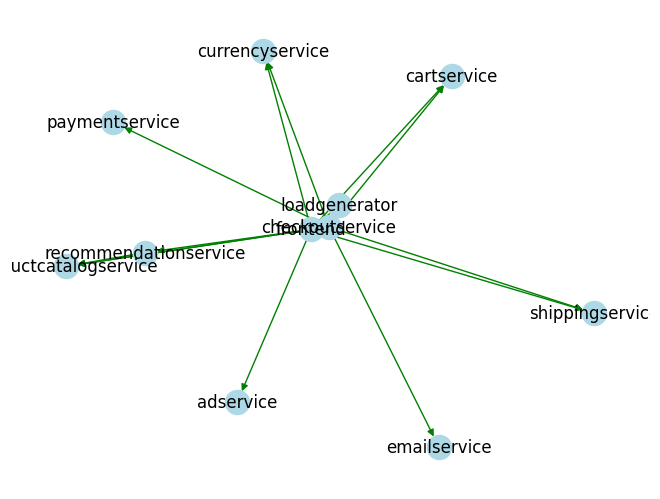

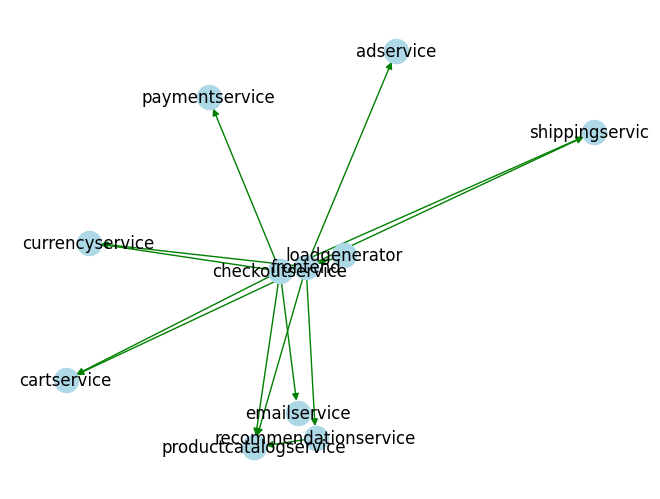

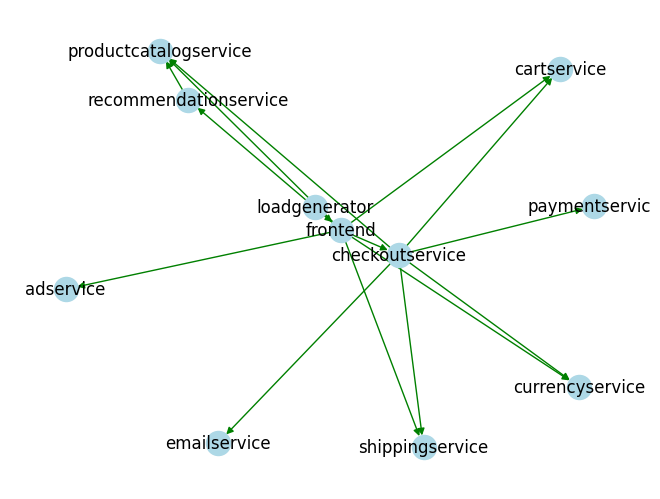

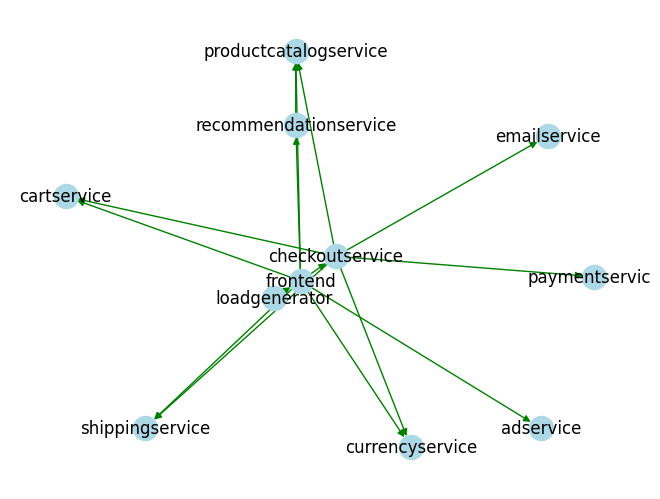

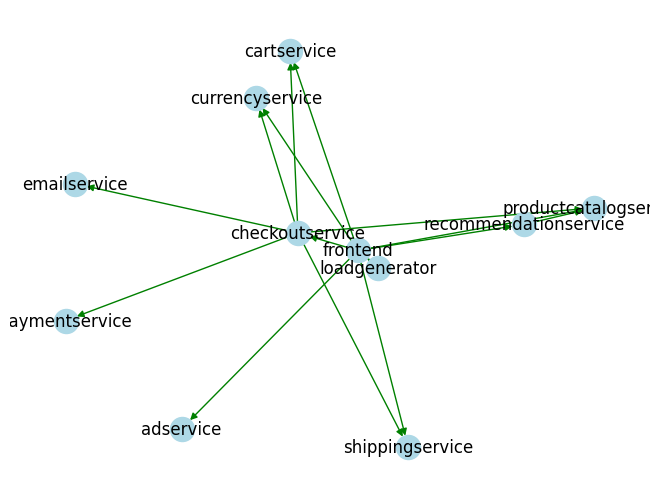

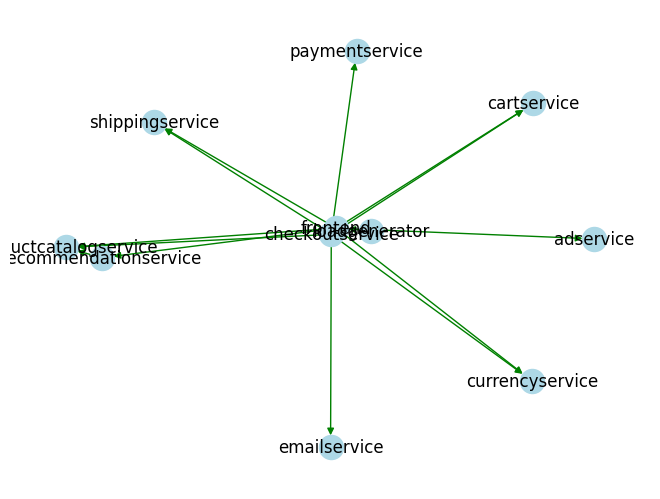

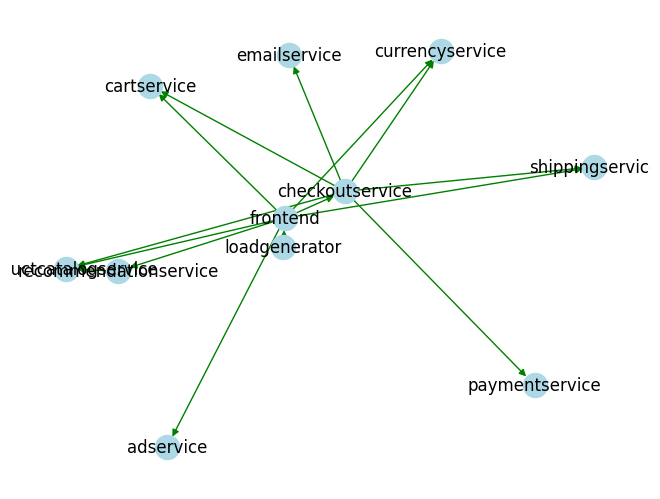

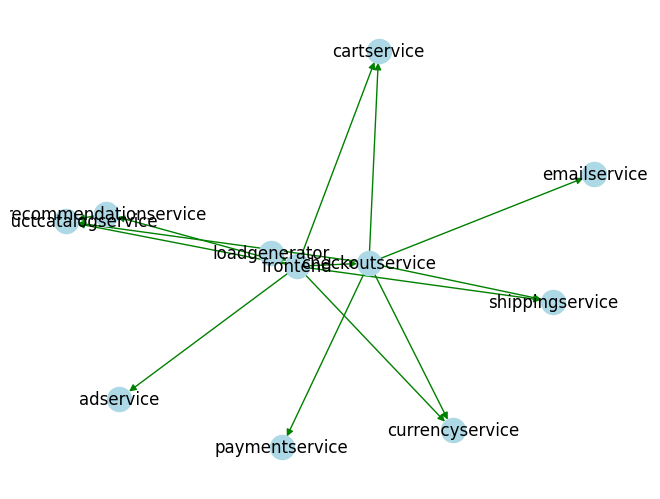

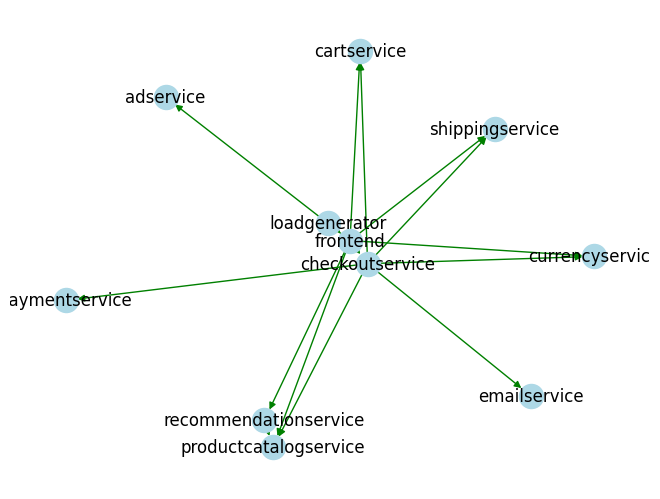

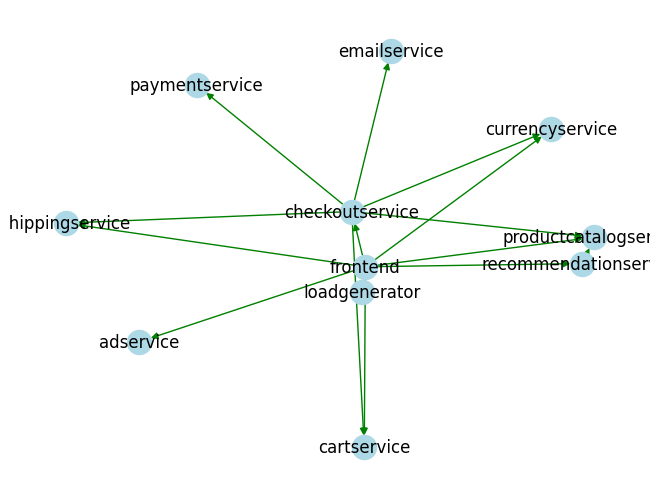

In [31]:
#Temporal Knowledge Graphs construction
g_tkg = rp.Graph()
g_tkg.load_edges_from_pandas(
df=data,
time="timestamp",
src="source_workload",
dst="destination_workload",
properties=["node","request_protocol" ,"response_code", "response_flags","grpc_response_status","class","total_request","istio_request_bytes_sum","istio_request_duration_milliseconds_sum"],
)

for i in range(number_of_windows):
    start_date=window_generated[i]-relativedelta(hours=1)
    end_date=window_generated[i+1]-relativedelta(hours=1)
    print(start_date,end_date)
    e = g_tkg.window(start_date,end_date)
    print(e)
    nx_g = e.to_networkx()
    plt.figure(i)
    nx.draw(nx_g, with_labels=True, node_color="lightblue", edge_color="green")

plt.show()

In [32]:
# Anomaly Detection Using Traditional ML
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

data=pd.read_csv('istio_request_2 _v2.csv',delimiter='\t')#, delimiteurs=';')
data = data[['source_workload','destination_workload', 'class','total_request', 'istio_request_bytes_sum' ,'istio_request_duration_milliseconds_sum']]


df = pd.DataFrame(data)

# Encode categorical data (source and destination services)
df['source_workload'] = df['source_workload'].astype('category').cat.codes
df['destination_workload'] = df['destination_workload'].astype('category').cat.codes

# Features and labels
X = df.drop(columns=['class'])
y = df['class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define classifiers
classifiers = {
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # You can add more classifiers here
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy:.2f}")
    print(classification_report(y_test, y_pred, target_names=['Abnormal', 'Normal']))


Training SVM...
Accuracy for SVM: 0.97
              precision    recall  f1-score   support

    Abnormal       0.95      1.00      0.97      3421
      Normal       1.00      0.93      0.97      2710

    accuracy                           0.97      6131
   macro avg       0.98      0.97      0.97      6131
weighted avg       0.97      0.97      0.97      6131


Training KNN...
Accuracy for KNN: 1.00
              precision    recall  f1-score   support

    Abnormal       1.00      1.00      1.00      3421
      Normal       1.00      1.00      1.00      2710

    accuracy                           1.00      6131
   macro avg       1.00      1.00      1.00      6131
weighted avg       1.00      1.00      1.00      6131


Training Random Forest...
Accuracy for Random Forest: 1.00
              precision    recall  f1-score   support

    Abnormal       1.00      1.00      1.00      3421
      Normal       1.00      1.00      1.00      2710

    accuracy                           1.0

my_label_config = {'namespace': 'online-boutique3', 'source_workload':'checkoutservice','destination_app':'currencyservice'}
custom_query(query: str, params: dict = None)
metric_data = prom.get_metric_range_data(metric_name='istio_requests_total', label_config=my_label_config)
print(metric_data)
